In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# text summarization

In [3]:
import json

rouge = json.load(open("data/text_summarization_rouge.json"))

In [4]:
# nested dict to dataframe
show_wp = ["No Watermark", "$\delta$-reweight", "$\gamma$-reweight"]
john_wps = set()


def map_wp_str(wp_str):
    if "Delta" in wp_str:
        return show_wp[1]
    elif "Gamma" in wp_str:
        return show_wp[2]
    elif "John" in wp_str:
        import re

        delta = re.findall(r"delta=(\d+\.?\d*)", wp_str)[0]
        n = "Soft Red List" + f"($\delta$={delta})"
        john_wps.add(n)
        return n
    if wp_str == "None":
        return show_wp[0]
    else:
        raise ValueError("Unknown watermark: {}".format(wp_str))


df = pd.DataFrame.from_dict(
    [
        {"wp_str": map_wp_str(wp_str), "score": score_str, "value": score}
        for wp_str in rouge
        for score_str in rouge[wp_str]
        for score in rouge[wp_str][score_str]
    ],
)
john_wps = sorted(list(john_wps))
df.head()

,wp_str,score,value
0,No Watermark,rouge1,0.405405
1,No Watermark,rouge1,0.406504
2,No Watermark,rouge1,0.378788
3,No Watermark,rouge1,0.325581
4,No Watermark,rouge1,0.363636


Text(0.5, 0, 'Watermark')

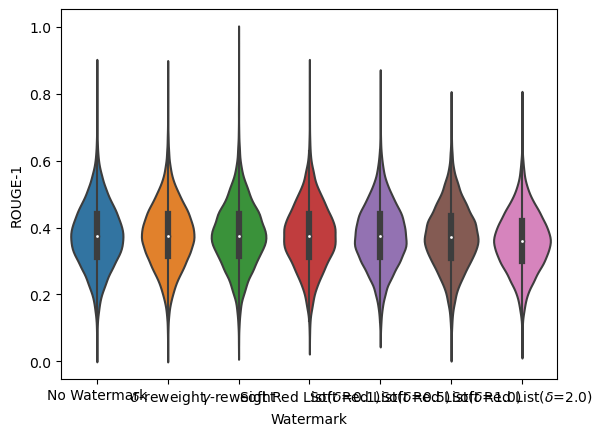

In [5]:
import seaborn as sns

sns.violinplot(
    data=df[df["score"] == "rouge1"], x="wp_str", y="value", order=show_wp + john_wps
)
plt.ylabel("ROUGE-1")
plt.xlabel("Watermark")

In [6]:
# form a table, rows are wp, columns are score, item is mean and std (of mean) like 0.5±0.001
sdf = df.groupby(["wp_str", "score"]).agg(["mean", "std", "count"])
sdf = (
    sdf["value"]
    .apply(
        lambda x: "{:.4f}±{:.4f}".format(x["mean"], x["std"] / np.sqrt(x["count"])),
        axis=1,
    )
    .unstack()
)
# reorder with the order of show_wp
sdf = sdf.loc[show_wp + john_wps]
sdf

score,rouge1,rouge2,rougeL
wp_str,,,
No Watermark,0.3763±0.0009,0.1320±0.0007,0.2382±0.0007
$\delta$-reweight,0.3773±0.0009,0.1328±0.0007,0.2388±0.0007
$\gamma$-reweight,0.3770±0.0009,0.1323±0.0007,0.2385±0.0007
Soft Red List($\delta$=0.1),0.3760±0.0009,0.1318±0.0007,0.2377±0.0007
Soft Red List($\delta$=0.5),0.3758±0.0009,0.1313±0.0007,0.2370±0.0007
Soft Red List($\delta$=1.0),0.3722±0.0009,0.1278±0.0007,0.2334±0.0007
Soft Red List($\delta$=2.0),0.3603±0.0008,0.1163±0.0007,0.2214±0.0007


# translation

In [11]:
bertscore = json.load(open("data/machine_translation_bertscore.json"))

In [18]:
# nested dict to dataframe
show_wp = ["No Watermark", "$\delta$-reweight", "$\gamma$-reweight"]
john_wps = set()


def map_wp_str(wp_str):
    if "Delta" in wp_str:
        return show_wp[1]
    elif "Gamma" in wp_str:
        return show_wp[2]
    elif "John" in wp_str:
        import re

        delta = re.findall(r"delta=(\d+\.?\d*)", wp_str)[0]
        n = "Soft Red List" + f"($\delta$={delta})"
        john_wps.add(n)
        return n
    if wp_str == "None":
        return show_wp[0]
    else:
        raise ValueError("Unknown watermark: {}".format(wp_str))


df = pd.DataFrame.from_dict(
    [
        {"wp_str": map_wp_str(wp_str), "score": score_str, "value": score}
        for wp_str in bertscore
        for score_str in bertscore[wp_str] if score_str != "hashcode"
        for score in bertscore[wp_str][score_str]
    ],
)
john_wps = sorted(list(john_wps))
df.head()

,wp_str,score,value
0,No Watermark,precision,-0.001005
1,No Watermark,precision,0.408567
2,No Watermark,precision,0.201200
3,No Watermark,precision,0.666245
4,No Watermark,precision,0.236957


Text(0.5, 0, 'Watermark')

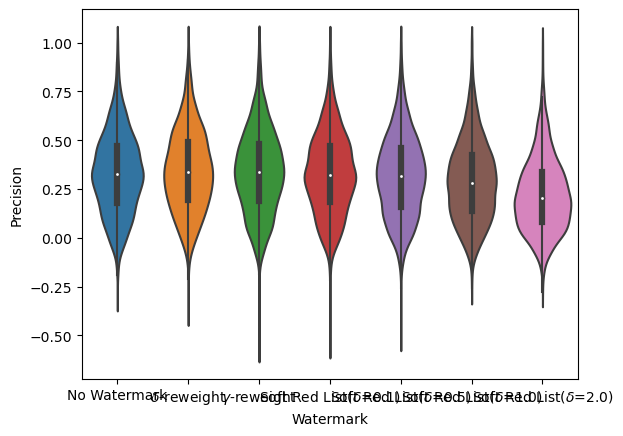

In [21]:
sns.violinplot(
    data=df[df["score"] == "precision"], x="wp_str", y="value", order=show_wp + john_wps
)
plt.ylabel("Precision")
plt.xlabel("Watermark")

In [22]:
# form a table, rows are wp, columns are score, item is mean and std (of mean) like 0.5±0.001
sdf = df.groupby(["wp_str", "score"]).agg(["mean", "std", "count"])
sdf = (
    sdf["value"]
    .apply(
        lambda x: "{:.4f}±{:.4f}".format(x["mean"], x["std"] / np.sqrt(x["count"])),
        axis=1,
    )
    .unstack()
)
# reorder with the order of show_wp
sdf = sdf.loc[show_wp + john_wps]
sdf

score,f1,precision,recall
wp_str,,,
No Watermark,0.3497±0.0037,0.3300±0.0038,0.3702±0.0037
$\delta$-reweight,0.3616±0.0037,0.3443±0.0038,0.3795±0.0038
$\gamma$-reweight,0.3578±0.0037,0.3388±0.0039,0.3775±0.0038
Soft Red List($\delta$=0.1),0.3479±0.0037,0.3284±0.0038,0.3679±0.0037
Soft Red List($\delta$=0.5),0.3388±0.0037,0.3180±0.0038,0.3604±0.0037
Soft Red List($\delta$=1.0),0.3165±0.0036,0.2919±0.0037,0.3422±0.0036
Soft Red List($\delta$=2.0),0.2535±0.0033,0.2229±0.0034,0.2856±0.0034
